# Homework 4: Modeling Text Data

### Team Member 1:
* Name: Shiemi Lim

### Team Member 2 [optional]:  
* Name: Sheallika Sign


You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

In [1]:
# Import libraries

%matplotlib inline
import numpy as np
from numpy import savetxt
import matplotlib.pyplot as plt
import sklearn
import pandas as pd 

import os
import csv
import math
# import nltk
import re
import itertools

# from nltk.stem import SnowballStemmer, WordNetLemmatizer
# from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import MaxAbsScaler
from IPython.display import Image
# from mglearn.tools import visualize_coefficients
from sklearn.cluster import KMeans
# nltk.download('all', halt_on_error=False)

In [2]:
# Load data
data_path = os.path.join("Vision_Zero_Entry.csv")
df = pd.read_csv(data_path, index_col=False, header=0)
df.head()

,X,Y,OBJECTID,GLOBALID,REQUESTID,REQUESTTYPE,REQUESTDATE,STATUS,STREETSEGID,COMMENTS,USERTYPE
0,-71.150057,42.287266,16807,NaN,16807.0,people cross away from the crosswalks,2016-01-21T14:27:24.000Z,Unassigned,0,"MBTA bus 35, 36, & 37 drop off passengers at B...",walks
1,-71.172684,42.271489,16808,NaN,16808.0,"the wait for the ""Walk"" signal is too long",2016-01-21T14:34:53.000Z,Unassigned,0,Dangerous intersection to cross for pedestrian...,walks
2,-71.100981,42.344888,17207,NaN,17207.0,of something that is not listed here,2016-01-22T14:11:08.000Z,Unassigned,0,A lot of the issues apply. Too much traffic go...,walks
3,-71.060474,42.358003,17208,NaN,17208.0,of something that is not listed here,2016-01-22T14:14:55.000Z,Unassigned,0,People turn from both the middle lane (not a t...,walks
4,-71.057073,42.338334,17209,NaN,17209.0,bike facilities don't exist or need improvement,2016-01-22T14:33:25.000Z,Unassigned,0,Dangerous pinch point for cyclists going North...,bikes


In [3]:
df.REQUESTTYPE.value_counts()

of something that is not listed here                                                                         1426
people speed                                                                                                 1224
bike facilities don't exist or need improvement                                                              1136
people run red lights / stop signs                                                                            790
people don't yield while turning                                                                              645
people double park their vehicles                                                                             631
it’s hard to see / low visibility                                                                             427
people don't yield while going straight                                                                       363
sidewalks/ramps don't exist or need improvement                                         

There are some empty columns, NANs, , ", let's delete them. 

In [4]:
df = df.dropna(subset=['COMMENTS'])
df = df[~df.REQUESTTYPE.str.startswith('"')]

df.REQUESTTYPE.value_counts()

of something that is not listed here                     1418
bike facilities don't exist or need improvement           782
people speed                                              737
people run red lights / stop signs                        660
people don't yield while turning                          461
people double park their vehicles                         426
it’s hard to see / low visibility                         384
sidewalks/ramps don't exist or need improvement           301
people don't yield while going straight                   263
people cross away from the crosswalks                     254
the roadway surface needs improvement                     221
the wait for the "Walk" signal is too long                204
there are no bike facilities or they need maintenance     128
there's not enough time to cross the street               121
it's too far / too many lanes to cross                     83
there are no sidewalks or they need maintenance            40
the road

In [5]:
# Replace variables with better renaming
df.REQUESTTYPE.replace("there are no bike facilities or they need maintenance", "bike facilities don't exist or need improvement", inplace=True)
df.REQUESTTYPE.replace('people have to wait too long for the "Walk" signal', 'the wait for the "Walk" signal is too long', inplace=True)
df.REQUESTTYPE.replace("sidewalks/ramps don't exist or need improvement", "there are no sidewalks or they need maintenance", inplace=True)
df.REQUESTTYPE.replace("the roadway surface needs maintenance", "the roadway surface needs improvement", inplace=True)
df.REQUESTTYPE.replace("people have to cross too many lanes / too far", "it's too far / too many lanes to cross", inplace=True)
df.REQUESTTYPE.replace("people are not given enough time to cross the street", "there's not enough time to cross the street", inplace=True)
df.REQUESTTYPE.replace("it’s hard for people to see each other", "it’s hard to see / low visibility", inplace=True)

In [6]:
df.REQUESTTYPE.value_counts()

of something that is not listed here               1418
bike facilities don't exist or need improvement     910
people speed                                        737
people run red lights / stop signs                  660
people don't yield while turning                    461
people double park their vehicles                   426
it’s hard to see / low visibility                   412
there are no sidewalks or they need maintenance     341
people don't yield while going straight             263
the roadway surface needs improvement               255
people cross away from the crosswalks               254
the wait for the "Walk" signal is too long          234
there's not enough time to cross the street         130
it's too far / too many lanes to cross              110
Name: REQUESTTYPE, dtype: int64

In [7]:
# Remove blanks from COMMENTS column 
df = df[df.COMMENTS != '']
df = df[df.COMMENTS.notnull()]
# Deduplicate
df.drop_duplicates(['REQUESTTYPE', 'COMMENTS'], inplace=True)

In [8]:
df.REQUESTTYPE.value_counts()

of something that is not listed here               1393
bike facilities don't exist or need improvement     817
people speed                                        734
people run red lights / stop signs                  647
people don't yield while turning                    452
people double park their vehicles                   420
it’s hard to see / low visibility                   404
there are no sidewalks or they need maintenance     337
people don't yield while going straight             255
people cross away from the crosswalks               254
the roadway surface needs improvement               249
the wait for the "Walk" signal is too long          224
there's not enough time to cross the street         130
it's too far / too many lanes to cross              107
Name: REQUESTTYPE, dtype: int64

In [9]:
req_type=[u"of something that is not listed here ","bike facilities don't exist or need improvement ",
u"people speed ",
u"people run red lights / stop signs ",
u"people don't yield while turning ",                  
u"people double park their vehicles ",                 
u"it’s hard to see / low visibility ",                  
u"there are no sidewalks or they need maintenance ",   
u"people cross away from the crosswalks",             
u"people don't yield while going straight",            
u"the roadway surface needs improvement",               
u"the wait for the 'Walk' signal is too long",         
u"there's not enough time to cross the street",         
u"it's too far / too many lanes to cross"]              

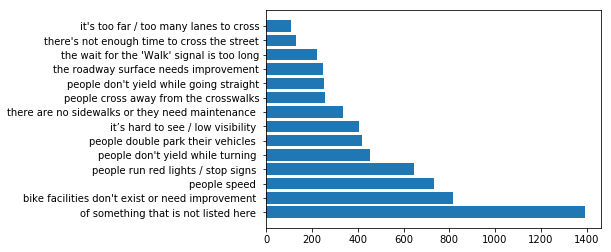

In [11]:
# Let's visualize the class distrbution
plt.clf()
distr = df.REQUESTTYPE.value_counts()
plt.barh(np.arange(len(distr)), distr)
plt.yticks(range(14),req_type);
# plt.yticks(np.arange(len(distr)), list(distr.index));

Notice there is a big "other" category. We will look into this later. 

In [12]:
y_vals = pd.factorize(df['REQUESTTYPE'])
y_vals[1]


Index(['people cross away from the crosswalks',
       'the wait for the "Walk" signal is too long',
       'of something that is not listed here',
       'bike facilities don't exist or need improvement',
       'people double park their vehicles', 'people speed',
       'it’s hard to see / low visibility',
       'people don't yield while going straight',
       'people don't yield while turning',
       'there are no sidewalks or they need maintenance',
       'people run red lights / stop signs',
       'it's too far / too many lanes to cross',
       'there's not enough time to cross the street',
       'the roadway surface needs improvement'],
      dtype='object')

In [13]:
requesttype = y_vals[0]
comments = df.COMMENTS

# Task2 - Model 1 [10 points]

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

In [14]:
#Let's split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(comments, requesttype, stratify=requesttype, random_state=45)

#### Grid search for logistic regression

In [15]:
X_train

4852    Lincoln Street runs 3/4 mile without stoplight...
6301    People continually drive WAY too fast down thi...
1199    Storrow bound traffic from the Anderson bridge...
5616    This intersection needs a light. People have t...
1825    EVERYONE on this road is too busy on their pho...
5620    When traffic is backed up drivers will pull in...
7895    The two way street sign put up two years ago o...
5221    Walk cycle crossing VFW is not long enough to ...
7934    People speed down Sedgwick St especially aroun...
7675    Pets routinely cross mass ave here away from t...
4381    Patrons of Robinwood Cafe and unmarked police ...
2639    The sidewalk is very torn up right as you turn...
4429    This location NEEEEEEEDS a pedestrian crossing...
7890    During little league season, numerous cars dou...
3929    trucks regularly roll through stop sign when e...
7262    Need a STOP sign for people coming down Stedma...
5748    It's difficult to see if cars are coming when ...
2490    The wa

In [16]:
pipe_base_model_cv = make_pipeline(TfidfVectorizer(),
                         LogisticRegressionCV(scoring='f1_macro', n_jobs=-1, multi_class='multinomial', class_weight='balanced'))
pipe_base_model_cv.fit(X_train, y_train)
y_pred = pipe_base_model_cv.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))
print(pipe_base_model_cv.named_steps['logisticregressioncv'].C_)

/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1119: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1119: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/andy/checkout/scikit-learn/sklearn/metrics/classification.py:1119: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.546865207163
[ 2.7825594  2.7825594  2.7825594  2.7825594  2.7825594  2.7825594
  2.7825594  2.7825594  2.7825594  2.7825594  2.7825594  2.7825594
  2.7825594  2.7825594]


Accuracy on test set

In [18]:
pipe_base_model = make_pipeline(TfidfVectorizer(),
                      LogisticRegression(n_jobs=-1, multi_class='multinomial', class_weight='balanced', C=2.783, solver='lbfgs'))
pipe_base_model.fit(X_train, y_train)
y_pred = pipe_base_model.predict(X_test)
score = f1_score(y_test, y_pred, average='macro')
print(score)

0.546865207163


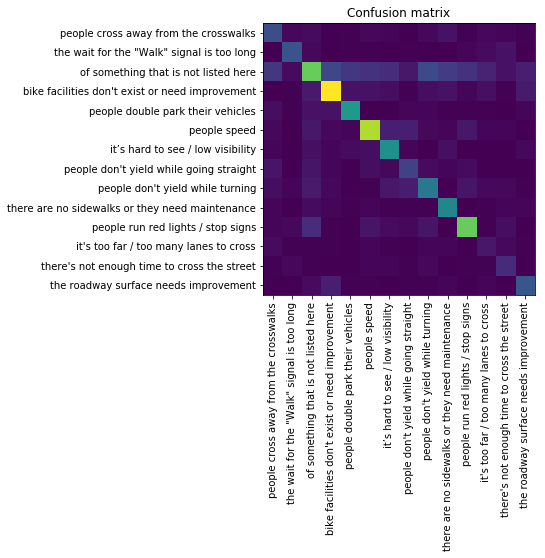

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest')
plt.yticks(range(len(cm)), y_vals[1].astype('unicode'), rotation='horizontal')
plt.xticks(range(len(cm)), y_vals[1].astype('unicode'), rotation=90)
plt.title('Confusion matrix')
plt.show()

/home/andy/checkout/scikit-learn/sklearn/utils/validation.py:431: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


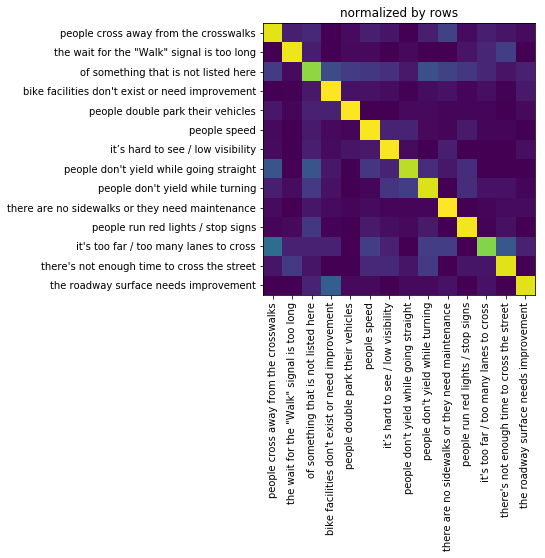

In [22]:
cm = normalize(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest')
plt.yticks(range(len(cm)), y_vals[1].astype('unicode'), rotation='horizontal')
plt.xticks(range(len(cm)), y_vals[1].astype('unicode'), rotation=90)
plt.title('normalized by rows')
plt.show()

Test score on testing set 

In [23]:
pipe_base_model.score(X_test, y_test)

0.57098381070983806

In [24]:
feature_names = pipe_base_model.named_steps['tfidfvectorizer'].get_feature_names()

In [25]:
def plot_important_features(coef, feature_names, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:10]
    high = inds[-10:]
    important = np.hstack([low, high])
    myrange = range(len(important))

    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=60, ha="right")

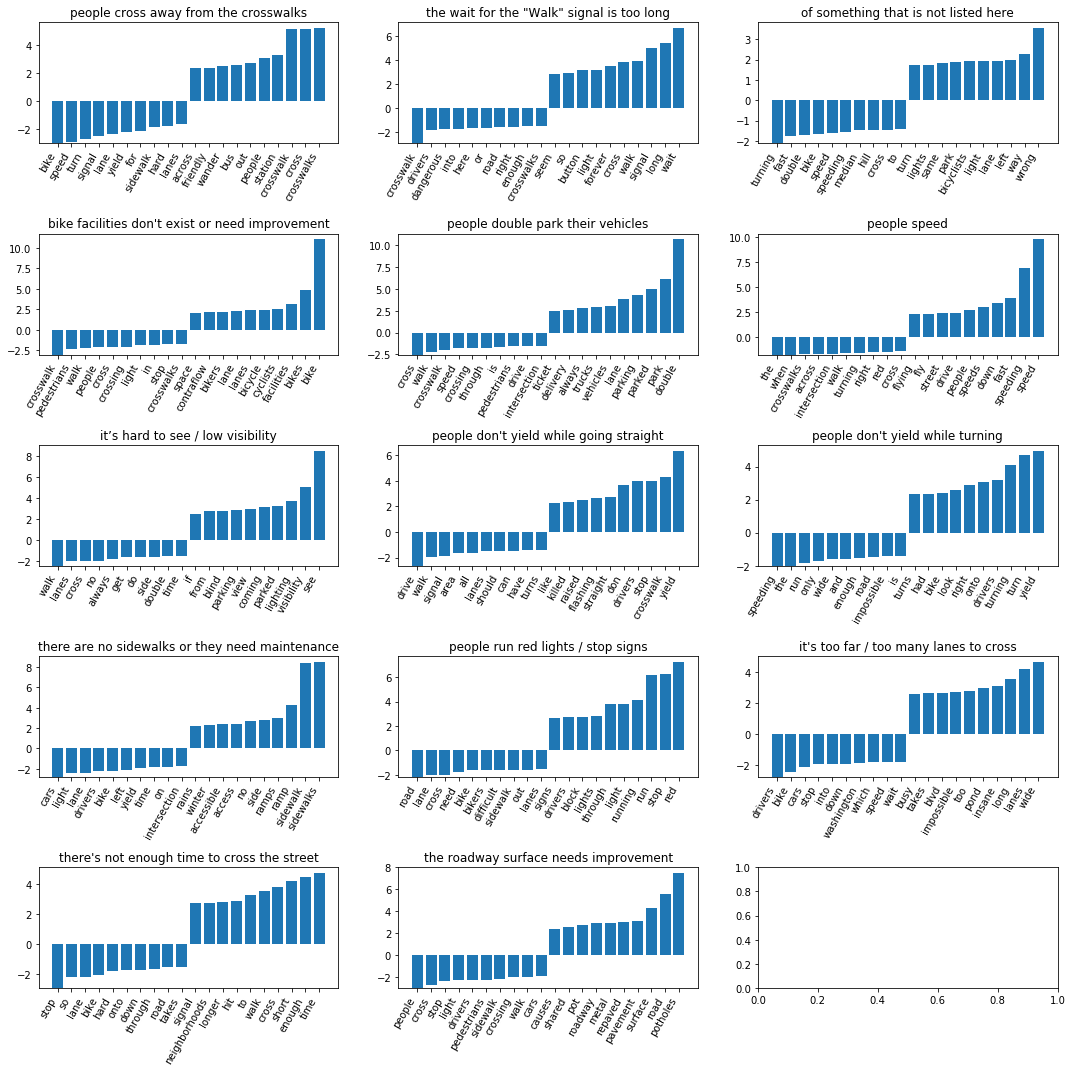

In [26]:
n_classes = len(pipe_base_model.named_steps['logisticregression'].classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 15))
for ax, coef, label in zip(axes.ravel(), pipe_base_model.named_steps['logisticregression'].coef_, y_vals[1].astype('unicode')):
    ax.set_title(label)
    plot_important_features(coef, np.array(feature_names), ax=ax)
plt.tight_layout()

# Task3 - Model 2 [30 points]

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

In [27]:
# Try Ngrams model
# Add your code for task 3 here. You may use multiple cells. 
vectorizer_ngrams = CountVectorizer(ngram_range=(1,10), stop_words="english", lowercase=True, min_df=2)
x_train_vectorized_ngrams = vectorizer_ngrams.fit_transform(X_train)
x_test_vectorized_ngrams = vectorizer_ngrams.transform(X_test)

In [28]:
x_train_vectorized_ngrams

<4817x13395 sparse matrix of type '<class 'numpy.int64'>'
	with 94603 stored elements in Compressed Sparse Row format>

In [29]:
x_test_vectorized_ngrams

<1606x13395 sparse matrix of type '<class 'numpy.int64'>'
	with 27052 stored elements in Compressed Sparse Row format>

In [30]:
lr_ngrams = LogisticRegression(C=2.783).fit(x_train_vectorized_ngrams, y_train)

y_test_pred_ngrams = lr_ngrams.predict(x_test_vectorized_ngrams)

In [31]:
f1_score(y_test, y_test_pred_ngrams, average="macro")

0.52325835220315609

In [32]:
confusion_matrix(y_test, y_test_pred_ngrams)

array([[ 33,   3,  12,   0,   1,   4,   2,   0,   1,   5,   1,   1,   1,
          0],
       [  0,  34,  11,   0,   0,   2,   0,   0,   0,   1,   4,   0,   4,
          0],
       [ 15,   4, 182,  27,   8,  22,  15,   6,  19,  24,  20,   1,   3,
          2],
       [  0,   0,  19, 153,   5,   6,   2,   0,   1,   8,   3,   0,   1,
          6],
       [  2,   0,  20,   7,  68,   0,   2,   1,   1,   0,   3,   0,   0,
          1],
       [  3,   0,  21,   2,   2, 133,   5,   5,   2,   1,   8,   1,   1,
          0],
       [  0,   0,  28,   2,   2,   9,  51,   1,   2,   2,   3,   1,   0,
          0],
       [  2,   0,  21,   3,   0,   7,   4,  18,   6,   1,   2,   0,   0,
          0],
       [  4,   4,  28,   1,   0,   4,   6,   4,  53,   0,   9,   0,   0,
          0],
       [  2,   0,  11,   4,   1,   4,   2,   0,   3,  55,   0,   0,   0,
          2],
       [  1,   3,  28,   1,   1,  14,   3,   3,   4,   0, 103,   0,   1,
          0],
       [  5,   1,   8,   1,   0,   7,   1, 

/home/andy/checkout/scikit-learn/sklearn/utils/validation.py:431: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, DataConversionWarning)


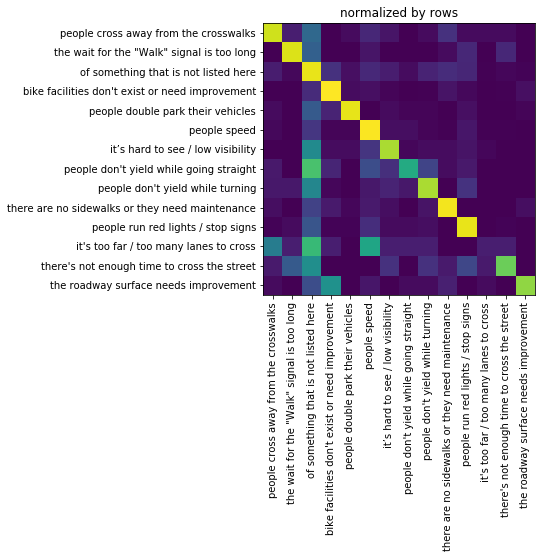

In [33]:
cm = normalize(confusion_matrix(y_test, y_test_pred_ngrams))
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest')
plt.yticks(range(len(cm)), y_vals[1].astype('unicode'), rotation='horizontal')
plt.xticks(range(len(cm)), y_vals[1].astype('unicode'), rotation=90)
plt.title('normalized by rows')
plt.show()

In [34]:
#Try character n-grams model
vectorizer_char_ngrams = CountVectorizer(ngram_range=(1,10), stop_words="english", analyzer="char_wb", lowercase=True, min_df=5)
x_train_vectorized_char_ngrams = vectorizer_char_ngrams.fit_transform(X_train)
x_test_vectorized_char_ngrams = vectorizer_char_ngrams.transform(X_test)

In [35]:
lr_char_ngrams = LogisticRegression().fit(x_train_vectorized_char_ngrams, y_train)
y_test_pred_char_ngrams = lr_char_ngrams.predict(x_test_vectorized_char_ngrams)

In [36]:
f1_score(y_test, y_test_pred_char_ngrams, average="macro")

0.50264774997287553

In [162]:
confusion_matrix(y_test, y_test_pred_char_ngrams) 

array([[130,   7,   2,   0,   1,   4,   2,  33,   1,   9,   0,   3,  12,
          0],
       [  7, 119,  11,   1,   7,   2,   2,  22,   8,   0,   2,   1,   0,
          3],
       [  3,  11,  97,   0,   5,   0,   6,  30,   5,   2,   2,   0,   0,
          1],
       [  1,   4,   2,  25,   3,   2,   2,  16,   2,   2,   1,   3,   0,
          1],
       [  2,   9,   5,   2,  15,   0,  11,  13,   3,   1,   1,   2,   0,
          0],
       [  2,   5,   0,   2,   1,   8,   1,   6,   1,   0,   0,   1,   0,
          0],
       [  5,   7,   8,   1,   9,   0,  45,  30,   2,   1,   2,   2,   1,
          0],
       [ 28,  18,  20,  21,   6,   3,  23, 173,  15,  10,   7,  16,   6,
          2],
       [  2,  10,   4,   0,   5,   1,   5,  19,  50,   1,   0,   4,   1,
          0],
       [  6,   2,   0,   2,   0,   0,   0,  21,   2,  68,   1,   2,   1,
          0],
       [  2,   1,   2,   1,   0,   0,   2,   4,   0,   0,  39,   1,   0,
          4],
       [  6,   1,   0,   2,   1,   0,   0, 

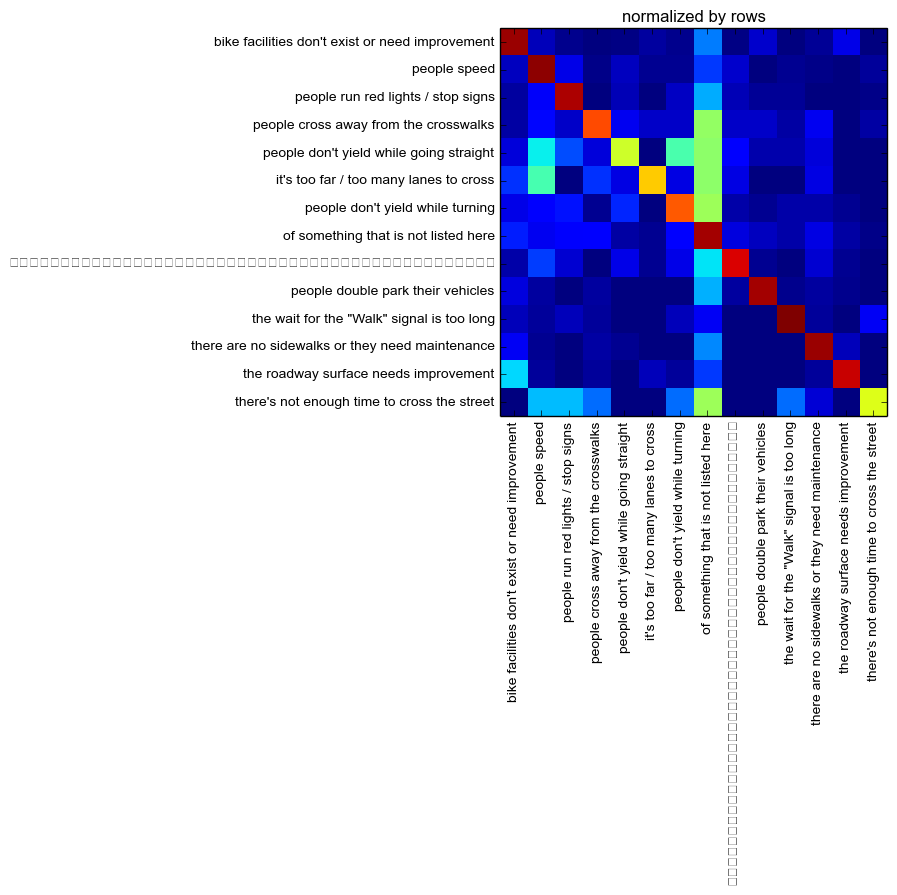

In [164]:
cm = normalize(confusion_matrix(y_test, y_test_pred_char_ngrams))
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest')
plt.yticks(range(len(cm)), y_vals[1].astype('unicode'), rotation='horizontal')
plt.xticks(range(len(cm)), y_vals[1].astype('unicode'), rotation=90)
plt.title('normalized by rows')
plt.show()

In [167]:
pipe_tfidf = make_pipeline(TfidfVectorizer(ngram_range=(1,2), stop_words='english'),
                      LogisticRegression(n_jobs=-1, multi_class='multinomial', class_weight='balanced', C=2.783, solver='lbfgs'))
pipe_tfidf.fit(X_train, y_train)
y_pred = pipe_tfidf.predict(X_test)


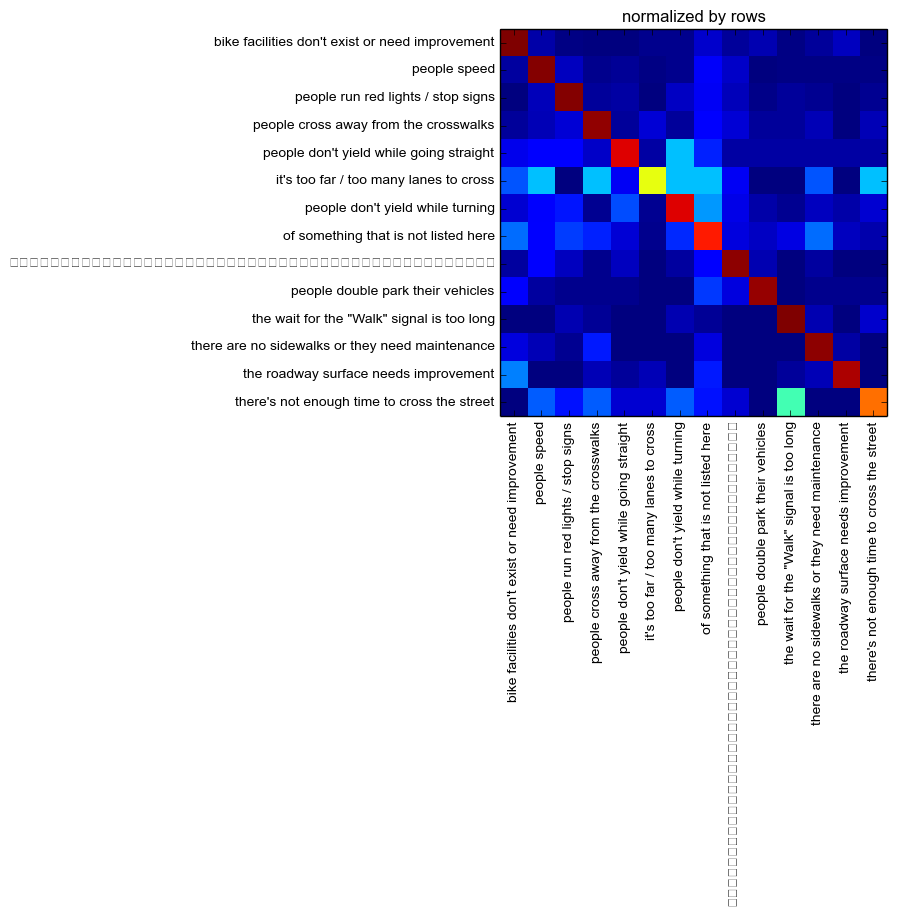

In [168]:
cm = normalize(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(5, 6))
plt.imshow(cm, interpolation='nearest')
plt.yticks(range(len(cm)), y_vals[1].astype('unicode'), rotation='horizontal')
plt.xticks(range(len(cm)), y_vals[1].astype('unicode'), rotation=90)
plt.title('normalized by rows')
plt.show()

In [169]:
pipe_tfidf.score(X_test, y_test)

0.5922933499067744

In [171]:
feature_names = pipe_tfidf.named_steps['tfidfvectorizer'].get_feature_names()

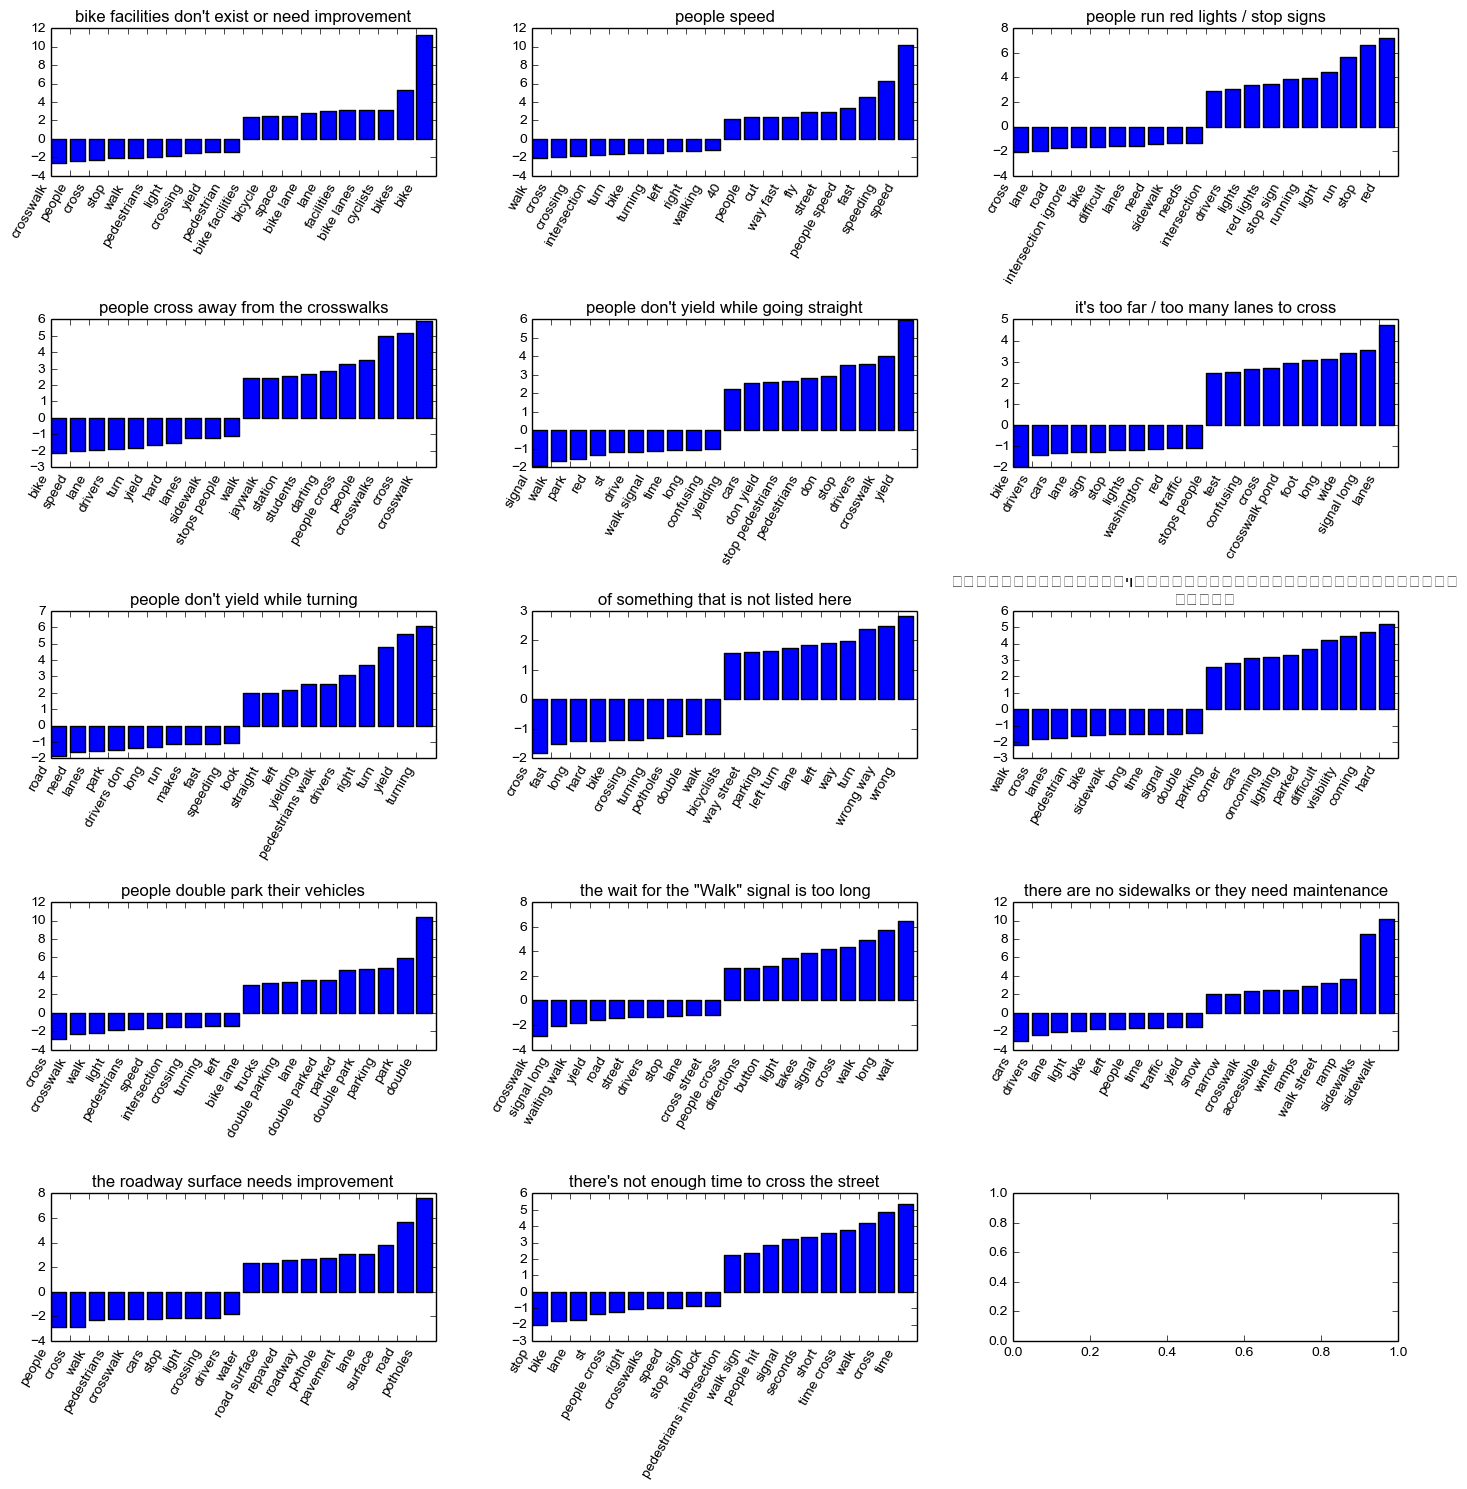

In [172]:
n_classes = len(pipe_tfidf.named_steps['logisticregression'].classes_)
fig, axes = plt.subplots(n_classes // 3 + 1, 3, figsize=(15, 15))
for ax, coef, label in zip(axes.ravel(), pipe_tfidf.named_steps['logisticregression'].coef_, y_vals[1].astype('unicode')):
    ax.set_title(label)
    plot_important_features(coef, np.array(feature_names), ax=ax)
plt.tight_layout()

# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

#### LDA

In [187]:
clusterVectorizer = CountVectorizer(ngram_range=(1, 3), min_df=2,stop_words='english').fit(X_train)
X_fullDataVectorized = clusterVectorizer.transform(X_train)



In [191]:

lda = LatentDirichletAllocation(n_topics=10, learning_method="batch",random_state=42)
X_lda = lda.fit_transform(X_fullDataVectorized)

In [195]:
adjusted_rand_score(y_train, np.argmax(X_lda,axis =1))

0.064758769201738051

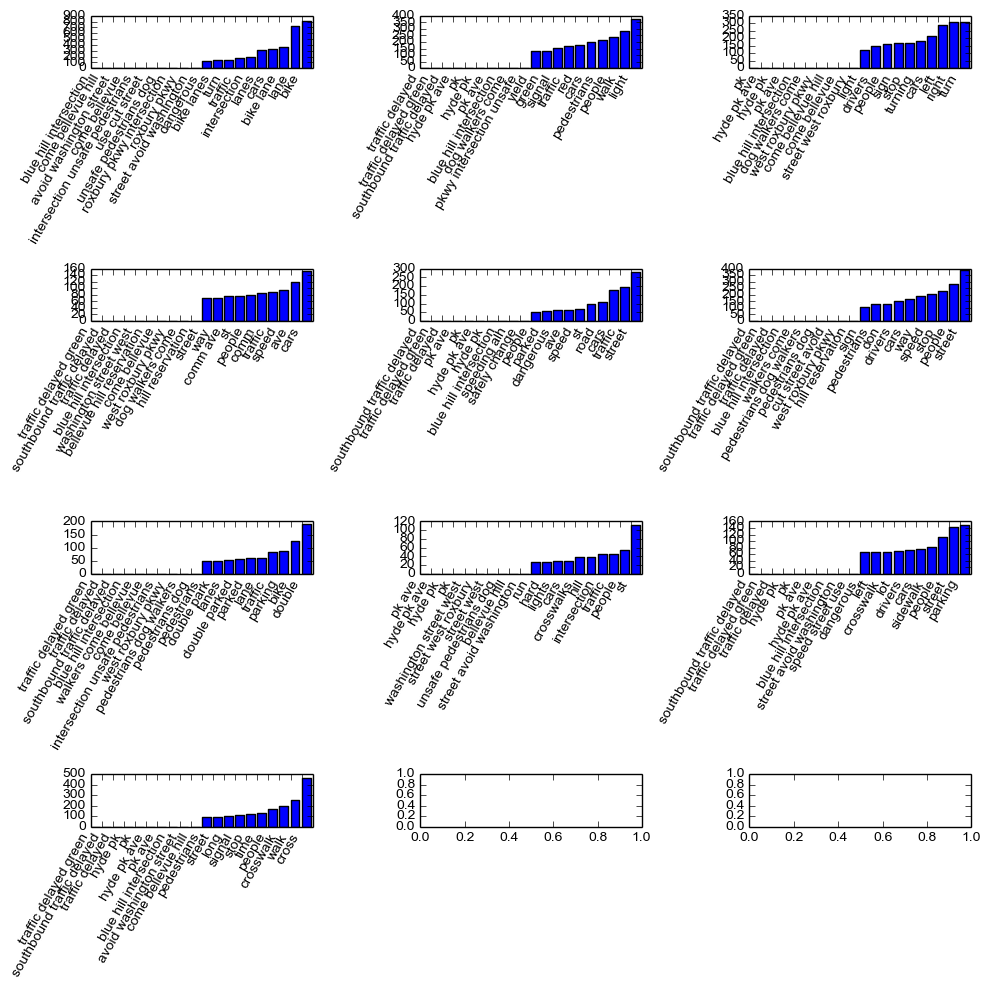

In [197]:
feature_names = np.array(clusterVectorizer.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), lda.components_):
    plot_important_features(coef, feature_names, ax=ax)
    
plt.tight_layout()

#### NMF

In [198]:
scaler = MaxAbsScaler()
X_fullData_scaled = scaler.fit_transform(X_fullDataVectorized)

In [200]:
nmf = NMF(n_components=9, verbose=0, tol=0.01)
X_nm_scale = nmf.fit_transform(X_fullData_scaled)

print(adjusted_rand_score(y_train, np.argmax(X_nm_scale,axis =1)))

0.131096938409


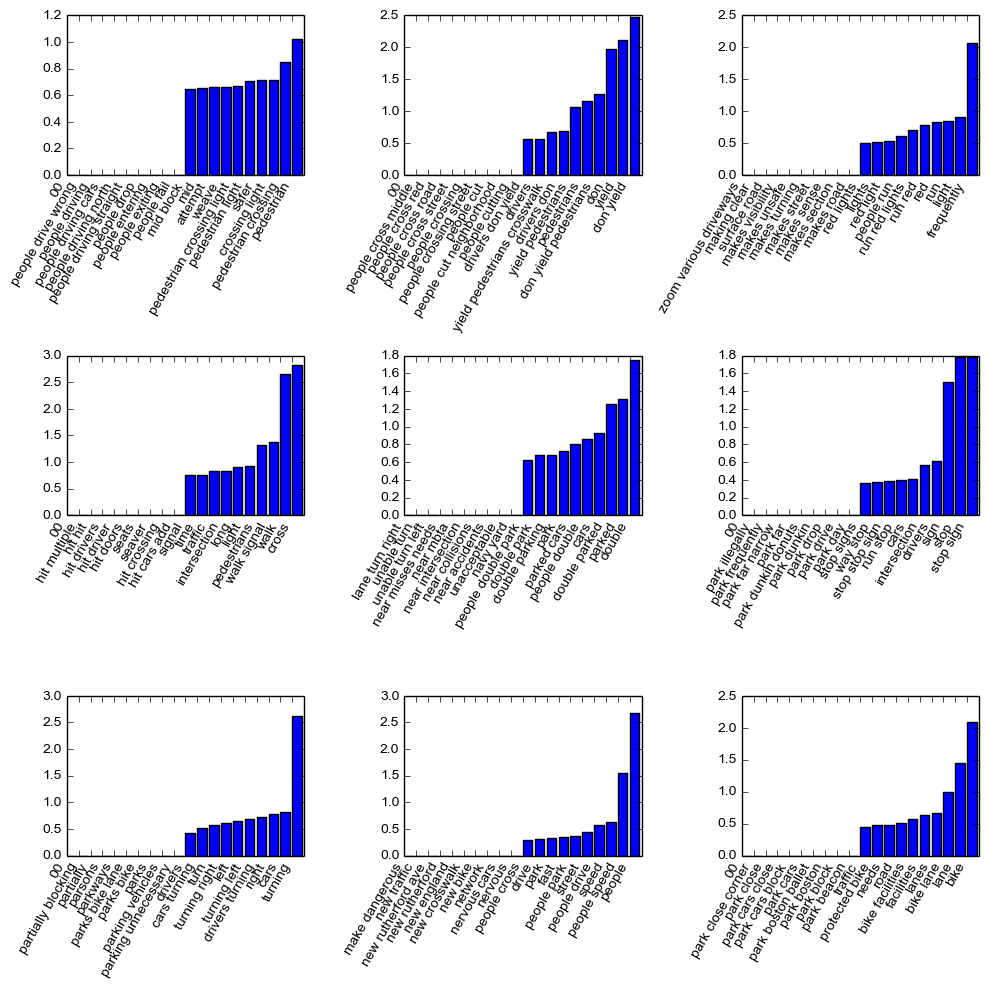

In [201]:
#NMF Visualization 9 components
large_comp_inds = np.argsort(X_nm_scale.mean(axis=0))

feature_names = np.array(clusterVectorizer.get_feature_names())
n_components = 6
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), nmf.components_[large_comp_inds, :]):
    plot_important_features(coef, feature_names,  ax=ax)
    
plt.tight_layout()

#### Kmeans

In [202]:
km = KMeans(n_clusters=14).fit(X_fullData_scaled)

In [204]:
from sklearn.decomposition import TruncatedSVD
comp_pca = TruncatedSVD(n_components=2).fit_transform(X_fullData_scaled)
yLabels=pd.factorize(y_train)

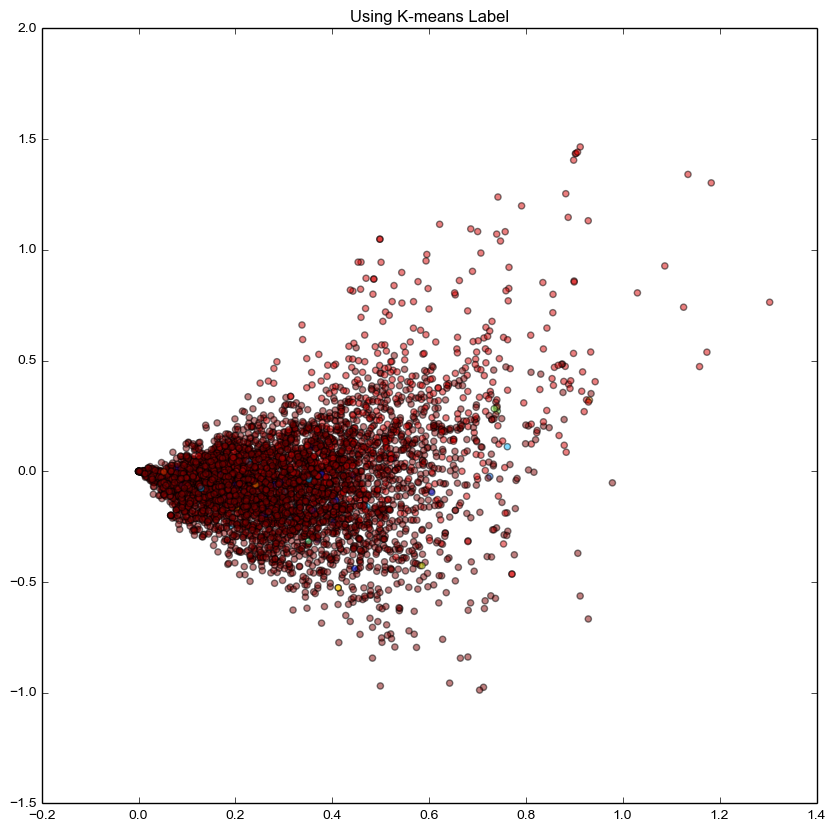

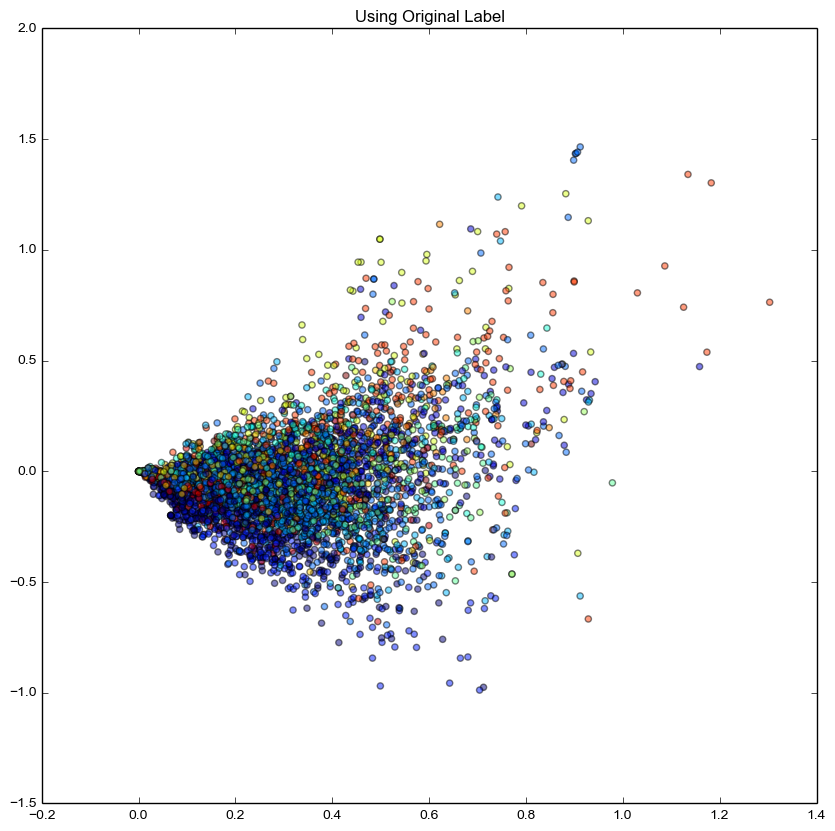

In [205]:


plt.figure(figsize=[10,10])
plt.scatter(comp_pca[:, 0], comp_pca[:, 1], c=km.labels_, alpha=.5)
plt.title('Using K-means Label')
plt.show()
plt.figure(figsize=[10,10])
plt.title('Using Original Label')
plt.scatter(comp_pca[:, 0], comp_pca[:, 1], c=yLabels[0], alpha=.5)
plt.show()



# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


In [204]:
# Add your code for task 6 here. You may use multiple cells. 



# Extra Credit [Up to +20 points]

Use a word embedding representation like word2vec for step 3 and or step 6. 

In [205]:
# Add your code for extra credit here. You may use multiple cells. 

